<a href="https://www.kaggle.com/code/siddp6/skip-connection-mnist?scriptVersionId=139515972" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Skip Connection

## Why we need Skip Connection?

- **Hidden layers**: The hidden layers are responsible for learning and representing increasingly complex patterns and features in the data.  The purpose of hidden layers is to transform the input data into more meaningful and abstract representations that capture the underlying relationships within the data.
- Okay, so with each hidden layer help to identify more favourable pattern, so with more hidden layer means our model will be able to pick the pattern more accurately. But in actually **with more hidden layer, models start to lose accuracy**. And this phenomas is called **Vanishing gradient Problem.**
- Reason for this, it is quite easy. Deep learning model use a concept called **Backpropagation**, which means model will use some weight to run the model, then it will make prediction and cacluate the loss. Then using  backpropagation it tell previous layers to update the weight in such a way to minimze the loss using **gradients**. But this gradients will get weaker and weaker as it pass throught layer.
- **In short, During the backpropagation process, gradients get smaller and smaller as they propagate back through the layers. As a result, the early layers of the network receive very small gradients, which can cause slow or ineffective learning.**
- To solve this problem we need Skip Connection

# What is skip Connection (also known as residual connection)?
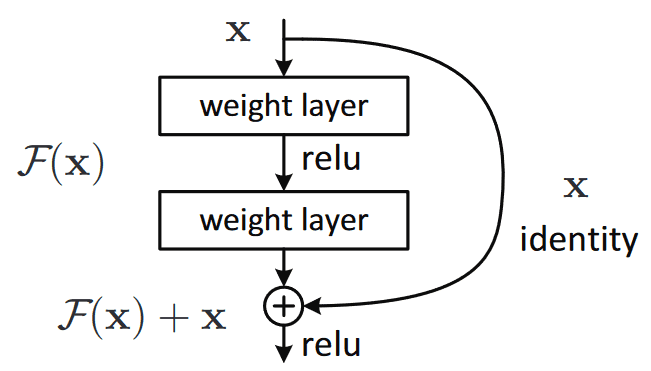

- The concept of skip connections was first introduced in the "ResNet" (Residual Network) architecture by Kaiming He et al. in their 2015 paper "Deep Residual Learning for Image Recognition." In ResNet, each layer is defined as: **Output = Activation(Layer(Input)) + Input**
- Here, the output of a layer is obtained by adding the output of a convolutional operation (with an activation function applied) to the input of the layer. By doing so, the network is encouraged to **learn residuals (differences) between the input and the desired output**, rather than directly learning the mapping. 
- When gradients are backpropagated, the direct connections provided by the skip connections allow the gradients to flow without getting severely diminished by the intermediate layers.

# Let us see the example 
(this is very basic exmple to show now skip connection can reduce the loss when we increase the number of hidden layer)

> Go to last cell to see the analysis

# Imports

In [1]:
# my utility: https://www.kaggle.com/code/siddp6/utility
import deep_learning_utility as utility

In [2]:
# Importing necessary libraries for working with PyTorch neural networks and optimization.

import torch
import multiprocessing
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms

# Initalisation

In [3]:
num_workers = multiprocessing.cpu_count()
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])
train_val_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
epochs = 100

100%|██████████| 9912422/9912422 [00:00<00:00, 123525844.89it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 103534781.05it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 32115253.58it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7389654.29it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
train_len = int(len(train_val_data) * 0.80)  # 80% for training
val_len = int(len(train_val_data) * 0.20)   # 20% for validation

train_subset, val_subset = torch.utils.data.random_split(
    train_val_data, [train_len, val_len], generator=torch.Generator().manual_seed(42)
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_subset, shuffle=True, batch_size=batch_size, num_workers=num_workers
)
val_loader = torch.utils.data.DataLoader(
    dataset=train_subset, shuffle=True, batch_size=batch_size, num_workers=num_workers
)

# Normal Model (5 layered) (without skip-connection)

In [5]:
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        
        self.linear1 = nn.Linear(784, 128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, 128)
        self.linear4 = nn.Linear(128, 128)
        self.linear5 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 10)
        
        self.relu = nn.ReLU()

        
    def forward(self, x):
        x = x.view(-1, 28*28)
            
        # Applying the first linear layer
        x = self.linear1(x)
        x = self.relu(x)
        
        # Applying the second linear layer
        x = self.linear2(x)
        x = self.relu(x)
        
        # Applying the third linear layer
        x = self.linear3(x)
        x = self.relu(x)

        # Applying the fourth linear layer
        x = self.linear4(x)
        x = self.relu(x)

        # Applying the fifth linear layer
        x = self.linear5(x)
        x = self.relu(x)
        
        x = self.output(x)
        x = self.relu(x)
        
        return x

In [6]:
normal_model_5 = Net5()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(normal_model_5.parameters(), lr=.01)
loss_normal_5,_ = utility.train(model=normal_model_5, epochs=epochs, train_loader=train_loader, optimizer=optimizer, criterion=criterion, val_loader=val_loader, is_cuda=False)

Epochs:   1%|▎                                  | 1/100 [00:14<23:31, 14.25s/it]

Epoch: 1 	Validation Loss: 2.299609
Epoch: 1 	Training Loss: 2.301644


Epochs:   2%|▋                                  | 2/100 [00:27<22:45, 13.94s/it]

Epoch: 2 	Validation Loss: 2.282943
Epoch: 2 	Training Loss: 2.293972


Epochs:   3%|█                                  | 3/100 [00:42<22:51, 14.14s/it]

Epoch: 3 	Validation Loss: 2.010295
Epoch: 3 	Training Loss: 2.206305


Epochs:   4%|█▍                                 | 4/100 [00:55<22:17, 13.93s/it]

Epoch: 4 	Validation Loss: 1.539309
Epoch: 4 	Training Loss: 1.708899


Epochs:   5%|█▊                                 | 5/100 [01:10<22:19, 14.10s/it]

Epoch: 5 	Validation Loss: 1.411737
Epoch: 5 	Training Loss: 1.485432


Epochs:   6%|██                                 | 6/100 [01:24<21:55, 13.99s/it]

Epoch: 6 	Validation Loss: 1.325676
Epoch: 6 	Training Loss: 1.392227


Epochs:   7%|██▍                                | 7/100 [01:38<21:47, 14.06s/it]

Epoch: 7 	Validation Loss: 1.296876
Epoch: 7 	Training Loss: 1.279866


Epochs:   8%|██▊                                | 8/100 [01:52<21:28, 14.01s/it]

Epoch: 8 	Validation Loss: 0.986699
Epoch: 8 	Training Loss: 1.086633


Epochs:   9%|███▏                               | 9/100 [02:06<21:10, 13.96s/it]

Epoch: 9 	Validation Loss: 0.931167
Epoch: 9 	Training Loss: 0.964824


Epochs:  10%|███▍                              | 10/100 [02:20<21:10, 14.12s/it]

Epoch: 10 	Validation Loss: 0.885017
Epoch: 10 	Training Loss: 0.915100


Epochs:  11%|███▋                              | 11/100 [02:34<20:47, 14.02s/it]

Epoch: 11 	Validation Loss: 0.868508
Epoch: 11 	Training Loss: 0.886565


Epochs:  12%|████                              | 12/100 [02:48<20:41, 14.11s/it]

Epoch: 12 	Validation Loss: 0.854327
Epoch: 12 	Training Loss: 0.868026


Epochs:  13%|████▍                             | 13/100 [03:02<20:22, 14.06s/it]

Epoch: 13 	Validation Loss: 0.835918
Epoch: 13 	Training Loss: 0.854083


Epochs:  14%|████▊                             | 14/100 [03:16<20:14, 14.13s/it]

Epoch: 14 	Validation Loss: 0.833796
Epoch: 14 	Training Loss: 0.843794


Epochs:  15%|█████                             | 15/100 [03:30<19:54, 14.05s/it]

Epoch: 15 	Validation Loss: 0.835518
Epoch: 15 	Training Loss: 0.833657


Epochs:  16%|█████▍                            | 16/100 [03:44<19:42, 14.07s/it]

Epoch: 16 	Validation Loss: 0.807292
Epoch: 16 	Training Loss: 0.824745


Epochs:  17%|█████▊                            | 17/100 [03:58<19:17, 13.94s/it]

Epoch: 17 	Validation Loss: 0.803855
Epoch: 17 	Training Loss: 0.815884


Epochs:  18%|██████                            | 18/100 [04:12<18:58, 13.89s/it]

Epoch: 18 	Validation Loss: 0.797881
Epoch: 18 	Training Loss: 0.810340


Epochs:  19%|██████▍                           | 19/100 [04:26<18:47, 13.92s/it]

Epoch: 19 	Validation Loss: 0.799121
Epoch: 19 	Training Loss: 0.804472


Epochs:  20%|██████▊                           | 20/100 [04:39<18:25, 13.81s/it]

Epoch: 20 	Validation Loss: 0.787665
Epoch: 20 	Training Loss: 0.804571


Epochs:  21%|███████▏                          | 21/100 [04:53<18:10, 13.81s/it]

Epoch: 21 	Validation Loss: 0.785402
Epoch: 21 	Training Loss: 0.793738


Epochs:  22%|███████▍                          | 22/100 [05:07<17:47, 13.68s/it]

Epoch: 22 	Validation Loss: 0.784457
Epoch: 22 	Training Loss: 0.789119


Epochs:  23%|███████▊                          | 23/100 [05:21<17:42, 13.79s/it]

Epoch: 23 	Validation Loss: 0.777958
Epoch: 23 	Training Loss: 0.784333


Epochs:  24%|████████▏                         | 24/100 [05:34<17:21, 13.70s/it]

Epoch: 24 	Validation Loss: 0.767939
Epoch: 24 	Training Loss: 0.781115


Epochs:  25%|████████▌                         | 25/100 [05:48<17:02, 13.63s/it]

Epoch: 25 	Validation Loss: 0.769337
Epoch: 25 	Training Loss: 0.778834


Epochs:  26%|████████▊                         | 26/100 [06:01<16:55, 13.72s/it]

Epoch: 26 	Validation Loss: 0.779488
Epoch: 26 	Training Loss: 0.774308


Epochs:  27%|█████████▏                        | 27/100 [06:15<16:33, 13.61s/it]

Epoch: 27 	Validation Loss: 0.758998
Epoch: 27 	Training Loss: 0.770882


Epochs:  28%|█████████▌                        | 28/100 [06:29<16:24, 13.68s/it]

Epoch: 28 	Validation Loss: 0.757469
Epoch: 28 	Training Loss: 0.767324


Epochs:  29%|█████████▊                        | 29/100 [06:42<16:04, 13.58s/it]

Epoch: 29 	Validation Loss: 0.754067
Epoch: 29 	Training Loss: 0.765760


Epochs:  30%|██████████▏                       | 30/100 [06:56<16:04, 13.78s/it]

Epoch: 30 	Validation Loss: 0.594092
Epoch: 30 	Training Loss: 0.722654


Epochs:  31%|██████████▌                       | 31/100 [07:10<15:50, 13.77s/it]

Epoch: 31 	Validation Loss: 0.547285
Epoch: 31 	Training Loss: 0.569107


Epochs:  32%|██████████▉                       | 32/100 [07:24<15:43, 13.88s/it]

Epoch: 32 	Validation Loss: 0.556876
Epoch: 32 	Training Loss: 0.555968


Epochs:  33%|███████████▏                      | 33/100 [07:38<15:23, 13.78s/it]

Epoch: 33 	Validation Loss: 0.538699
Epoch: 33 	Training Loss: 0.549138


Epochs:  34%|███████████▌                      | 34/100 [07:51<15:04, 13.70s/it]

Epoch: 34 	Validation Loss: 0.555021
Epoch: 34 	Training Loss: 0.547107


Epochs:  35%|███████████▉                      | 35/100 [08:05<14:59, 13.84s/it]

Epoch: 35 	Validation Loss: 0.570164
Epoch: 35 	Training Loss: 0.542655


Epochs:  36%|████████████▏                     | 36/100 [08:19<14:47, 13.86s/it]

Epoch: 36 	Validation Loss: 0.528124
Epoch: 36 	Training Loss: 0.536812


Epochs:  37%|████████████▌                     | 37/100 [08:33<14:37, 13.93s/it]

Epoch: 37 	Validation Loss: 0.531572
Epoch: 37 	Training Loss: 0.532773


Epochs:  38%|████████████▉                     | 38/100 [08:47<14:15, 13.79s/it]

Epoch: 38 	Validation Loss: 0.656921
Epoch: 38 	Training Loss: 0.531067


Epochs:  39%|█████████████▎                    | 39/100 [09:01<14:06, 13.88s/it]

Epoch: 39 	Validation Loss: 0.527714
Epoch: 39 	Training Loss: 0.530629


Epochs:  40%|█████████████▌                    | 40/100 [09:15<13:50, 13.85s/it]

Epoch: 40 	Validation Loss: 0.524336
Epoch: 40 	Training Loss: 0.524848


Epochs:  41%|█████████████▉                    | 41/100 [09:28<13:35, 13.82s/it]

Epoch: 41 	Validation Loss: 0.518796
Epoch: 41 	Training Loss: 0.523599


Epochs:  42%|██████████████▎                   | 42/100 [09:43<13:26, 13.90s/it]

Epoch: 42 	Validation Loss: 0.513150
Epoch: 42 	Training Loss: 0.522582


Epochs:  43%|██████████████▌                   | 43/100 [09:56<13:03, 13.74s/it]

Epoch: 43 	Validation Loss: 0.510440
Epoch: 43 	Training Loss: 0.520377


Epochs:  44%|██████████████▉                   | 44/100 [10:10<12:51, 13.77s/it]

Epoch: 44 	Validation Loss: 0.526647
Epoch: 44 	Training Loss: 0.517626


Epochs:  45%|███████████████▎                  | 45/100 [10:23<12:27, 13.59s/it]

Epoch: 45 	Validation Loss: 0.511730
Epoch: 45 	Training Loss: 0.515445


Epochs:  46%|███████████████▋                  | 46/100 [10:37<12:13, 13.59s/it]

Epoch: 46 	Validation Loss: 0.510954
Epoch: 46 	Training Loss: 0.512748


Epochs:  47%|███████████████▉                  | 47/100 [10:50<11:55, 13.50s/it]

Epoch: 47 	Validation Loss: 0.505539
Epoch: 47 	Training Loss: 0.511369


Epochs:  48%|████████████████▎                 | 48/100 [11:03<11:36, 13.39s/it]

Epoch: 48 	Validation Loss: 0.506993
Epoch: 48 	Training Loss: 0.509980


Epochs:  49%|████████████████▋                 | 49/100 [11:17<11:28, 13.51s/it]

Epoch: 49 	Validation Loss: 0.503636
Epoch: 49 	Training Loss: 0.510091


Epochs:  50%|█████████████████                 | 50/100 [11:30<11:12, 13.45s/it]

Epoch: 50 	Validation Loss: 0.514538
Epoch: 50 	Training Loss: 0.507266


Epochs:  51%|█████████████████▎                | 51/100 [11:44<11:04, 13.55s/it]

Epoch: 51 	Validation Loss: 0.502163
Epoch: 51 	Training Loss: 0.507722


Epochs:  52%|█████████████████▋                | 52/100 [11:57<10:47, 13.50s/it]

Epoch: 52 	Validation Loss: 0.503733
Epoch: 52 	Training Loss: 0.506669


Epochs:  53%|██████████████████                | 53/100 [12:11<10:39, 13.60s/it]

Epoch: 53 	Validation Loss: 0.552511
Epoch: 53 	Training Loss: 0.528813


Epochs:  54%|██████████████████▎               | 54/100 [12:24<10:21, 13.52s/it]

Epoch: 54 	Validation Loss: 0.508398
Epoch: 54 	Training Loss: 0.519072


Epochs:  55%|██████████████████▋               | 55/100 [12:38<10:06, 13.47s/it]

Epoch: 55 	Validation Loss: 0.501647
Epoch: 55 	Training Loss: 0.507819


Epochs:  56%|███████████████████               | 56/100 [12:52<09:57, 13.58s/it]

Epoch: 56 	Validation Loss: 0.502567
Epoch: 56 	Training Loss: 0.505511


Epochs:  57%|███████████████████▍              | 57/100 [13:05<09:38, 13.45s/it]

Epoch: 57 	Validation Loss: 0.500678
Epoch: 57 	Training Loss: 0.505625


Epochs:  58%|███████████████████▋              | 58/100 [13:18<09:27, 13.51s/it]

Epoch: 58 	Validation Loss: 0.502900
Epoch: 58 	Training Loss: 0.502846


Epochs:  59%|████████████████████              | 59/100 [13:32<09:11, 13.44s/it]

Epoch: 59 	Validation Loss: 0.503858
Epoch: 59 	Training Loss: 0.502430


Epochs:  60%|████████████████████▍             | 60/100 [13:45<08:59, 13.48s/it]

Epoch: 60 	Validation Loss: 0.498325
Epoch: 60 	Training Loss: 0.502333


Epochs:  61%|████████████████████▋             | 61/100 [13:58<08:42, 13.40s/it]

Epoch: 61 	Validation Loss: 0.498298
Epoch: 61 	Training Loss: 0.507726


Epochs:  62%|█████████████████████             | 62/100 [14:12<08:27, 13.35s/it]

Epoch: 62 	Validation Loss: 0.498009
Epoch: 62 	Training Loss: 0.500106


Epochs:  63%|█████████████████████▍            | 63/100 [14:25<08:17, 13.44s/it]

Epoch: 63 	Validation Loss: 0.496903
Epoch: 63 	Training Loss: 0.497897


Epochs:  64%|█████████████████████▊            | 64/100 [14:39<08:02, 13.39s/it]

Epoch: 64 	Validation Loss: 0.503592
Epoch: 64 	Training Loss: 0.497178


Epochs:  65%|██████████████████████            | 65/100 [14:52<07:51, 13.46s/it]

Epoch: 65 	Validation Loss: 0.494944
Epoch: 65 	Training Loss: 0.497086


Epochs:  66%|██████████████████████▍           | 66/100 [15:06<07:39, 13.51s/it]

Epoch: 66 	Validation Loss: 0.494838
Epoch: 66 	Training Loss: 0.497919


Epochs:  67%|██████████████████████▊           | 67/100 [15:20<07:32, 13.71s/it]

Epoch: 67 	Validation Loss: 0.499243
Epoch: 67 	Training Loss: 0.500444


Epochs:  68%|███████████████████████           | 68/100 [15:34<07:17, 13.68s/it]

Epoch: 68 	Validation Loss: 0.498662
Epoch: 68 	Training Loss: 0.496254


Epochs:  69%|███████████████████████▍          | 69/100 [15:47<07:04, 13.68s/it]

Epoch: 69 	Validation Loss: 0.494409
Epoch: 69 	Training Loss: 0.495793


Epochs:  70%|███████████████████████▊          | 70/100 [16:01<06:54, 13.82s/it]

Epoch: 70 	Validation Loss: 0.512629
Epoch: 70 	Training Loss: 0.566794


Epochs:  71%|████████████████████████▏         | 71/100 [16:15<06:39, 13.76s/it]

Epoch: 71 	Validation Loss: 0.503346
Epoch: 71 	Training Loss: 0.509067


Epochs:  72%|████████████████████████▍         | 72/100 [16:29<06:28, 13.88s/it]

Epoch: 72 	Validation Loss: 0.504907
Epoch: 72 	Training Loss: 0.501733


Epochs:  73%|████████████████████████▊         | 73/100 [16:43<06:12, 13.78s/it]

Epoch: 73 	Validation Loss: 0.505807
Epoch: 73 	Training Loss: 0.498294


Epochs:  74%|█████████████████████████▏        | 74/100 [16:57<06:00, 13.88s/it]

Epoch: 74 	Validation Loss: 0.493884
Epoch: 74 	Training Loss: 0.496921


Epochs:  75%|█████████████████████████▌        | 75/100 [17:11<05:47, 13.92s/it]

Epoch: 75 	Validation Loss: 0.494412
Epoch: 75 	Training Loss: 0.494663


Epochs:  76%|█████████████████████████▊        | 76/100 [17:25<05:38, 14.10s/it]

Epoch: 76 	Validation Loss: 0.493257
Epoch: 76 	Training Loss: 0.494595


Epochs:  77%|██████████████████████████▏       | 77/100 [17:39<05:23, 14.08s/it]

Epoch: 77 	Validation Loss: 0.492836
Epoch: 77 	Training Loss: 0.493533


Epochs:  78%|██████████████████████████▌       | 78/100 [17:54<05:10, 14.09s/it]

Epoch: 78 	Validation Loss: 0.492693
Epoch: 78 	Training Loss: 0.492789


Epochs:  79%|██████████████████████████▊       | 79/100 [18:08<04:58, 14.21s/it]

Epoch: 79 	Validation Loss: 0.492098
Epoch: 79 	Training Loss: 0.492472


Epochs:  80%|███████████████████████████▏      | 80/100 [18:23<04:45, 14.28s/it]

Epoch: 80 	Validation Loss: 0.491952
Epoch: 80 	Training Loss: 0.492270


Epochs:  89%|██████████████████████████████▎   | 89/100 [20:28<02:32, 13.82s/it]

Epoch: 89 	Validation Loss: 0.491247
Epoch: 89 	Training Loss: 0.491303


Epochs:  90%|██████████████████████████████▌   | 90/100 [20:43<02:19, 13.92s/it]

Epoch: 90 	Validation Loss: 0.491208
Epoch: 90 	Training Loss: 0.491292


Epochs:  91%|██████████████████████████████▉   | 91/100 [20:56<02:04, 13.79s/it]

Epoch: 91 	Validation Loss: 0.491222
Epoch: 91 	Training Loss: 0.491246


Epochs:  92%|███████████████████████████████▎  | 92/100 [21:10<01:50, 13.81s/it]

Epoch: 92 	Validation Loss: 0.491224
Epoch: 92 	Training Loss: 0.491227


Epochs:  93%|███████████████████████████████▌  | 93/100 [21:23<01:35, 13.67s/it]

Epoch: 93 	Validation Loss: 0.491221
Epoch: 93 	Training Loss: 0.491234


Epochs:  94%|███████████████████████████████▉  | 94/100 [21:37<01:21, 13.65s/it]

Epoch: 94 	Validation Loss: 0.491218
Epoch: 94 	Training Loss: 0.491184


Epochs:  95%|████████████████████████████████▎ | 95/100 [21:51<01:08, 13.67s/it]

Epoch: 95 	Validation Loss: 0.491123
Epoch: 95 	Training Loss: 0.491161


Epochs:  96%|████████████████████████████████▋ | 96/100 [22:04<00:54, 13.60s/it]

Epoch: 96 	Validation Loss: 0.491128
Epoch: 96 	Training Loss: 0.491144


Epochs:  97%|████████████████████████████████▉ | 97/100 [22:18<00:41, 13.69s/it]

Epoch: 97 	Validation Loss: 0.491099
Epoch: 97 	Training Loss: 0.491145


Epochs:  98%|█████████████████████████████████▎| 98/100 [22:31<00:27, 13.60s/it]

Epoch: 98 	Validation Loss: 0.491100
Epoch: 98 	Training Loss: 0.491122


Epochs:  99%|█████████████████████████████████▋| 99/100 [22:45<00:13, 13.68s/it]

Epoch: 99 	Validation Loss: 0.491090
Epoch: 99 	Training Loss: 0.491111


Epochs: 100%|█████████████████████████████████| 100/100 [22:59<00:00, 13.79s/it]

Epoch: 100 	Validation Loss: 0.491099
Epoch: 100 	Training Loss: 0.491104


# Skip Model (5 layered) (with skip-connection)

In [7]:
import torch.nn as nn

class skip_model_5(nn.Module):
    def __init__(self):
        super(skip_model_5, self).__init__()
        
        self.linear1 = nn.Linear(784, 128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, 128)
        self.linear4 = nn.Linear(128, 128)
        self.linear5 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 10)
        self.relu = nn.ReLU()

        
    def forward(self, x):
        x = x.view(-1, 28*28)
            
        # Applying the first linear layer
        out1 = self.linear1(x)
        out1 = self.relu(out1)
        
        # Applying the second linear layer
        out2 = self.linear2(out1)
        out2 = self.relu(out2)
        
        # Adding a skip connection (residual connection)
        out3 = out2 + out1
        
        # Applying the third linear layer
        out4 = self.linear3(out3)
        out4 = self.relu(out4)
        
        # Adding another skip connection
        out5 = out4 + out3
        
        # Applying the fourth linear layer
        out6 = self.linear4(out5)
        out6 = self.relu(out6)
        
        # Adding another skip connection
        out7 = out6 + out5
        
        # Applying the fifth linear layer
        out8 = self.linear5(out7)
        out8 = self.relu(out8)
        
        out9 = self.output(out8)
        out9 = self.relu(out9)
        
        return out9


In [8]:
skip_model_5 = skip_model_5()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(skip_model_5.parameters(), lr=.01)
_, loss_skip_5 = utility.train(model=skip_model_5, epochs=epochs, train_loader=train_loader, optimizer=optimizer, criterion=criterion, val_loader=val_loader, is_cuda=False)

Epochs:   1%|▎                                  | 1/100 [00:13<22:44, 13.78s/it]

Epoch: 1 	Validation Loss: 0.636407
Epoch: 1 	Training Loss: 1.121035


Epochs:   2%|▋                                  | 2/100 [00:27<22:19, 13.67s/it]

Epoch: 2 	Validation Loss: 0.300951
Epoch: 2 	Training Loss: 0.409949


Epochs:   3%|█                                  | 3/100 [00:40<22:02, 13.63s/it]

Epoch: 3 	Validation Loss: 0.230901
Epoch: 3 	Training Loss: 0.270190


Epochs:   4%|█▍                                 | 4/100 [00:54<22:00, 13.76s/it]

Epoch: 4 	Validation Loss: 0.204005
Epoch: 4 	Training Loss: 0.224687


Epochs:   5%|█▊                                 | 5/100 [01:08<21:34, 13.63s/it]

Epoch: 5 	Validation Loss: 0.170634
Epoch: 5 	Training Loss: 0.189583


Epochs:   6%|██                                 | 6/100 [01:22<21:36, 13.79s/it]

Epoch: 6 	Validation Loss: 0.144815
Epoch: 6 	Training Loss: 0.165389


Epochs:   7%|██▍                                | 7/100 [01:35<21:11, 13.67s/it]

Epoch: 7 	Validation Loss: 0.131250
Epoch: 7 	Training Loss: 0.145385


Epochs:   8%|██▊                                | 8/100 [01:49<20:59, 13.70s/it]

Epoch: 8 	Validation Loss: 0.117654
Epoch: 8 	Training Loss: 0.130973


Epochs:   9%|███▏                               | 9/100 [02:02<20:33, 13.56s/it]

Epoch: 9 	Validation Loss: 0.101590
Epoch: 9 	Training Loss: 0.118262


Epochs:  10%|███▍                              | 10/100 [02:16<20:14, 13.49s/it]

Epoch: 10 	Validation Loss: 0.090820
Epoch: 10 	Training Loss: 0.107144


Epochs:  11%|███▋                              | 11/100 [02:30<20:13, 13.63s/it]

Epoch: 11 	Validation Loss: 0.097862
Epoch: 11 	Training Loss: 0.098772


Epochs:  12%|████                              | 12/100 [02:43<19:49, 13.51s/it]

Epoch: 12 	Validation Loss: 0.086340
Epoch: 12 	Training Loss: 0.091038


Epochs:  13%|████▍                             | 13/100 [02:57<19:44, 13.61s/it]

Epoch: 13 	Validation Loss: 0.076169
Epoch: 13 	Training Loss: 0.083732


Epochs:  14%|████▊                             | 14/100 [03:10<19:25, 13.56s/it]

Epoch: 14 	Validation Loss: 0.064922
Epoch: 14 	Training Loss: 0.077765


Epochs:  15%|█████                             | 15/100 [03:24<19:21, 13.67s/it]

Epoch: 15 	Validation Loss: 0.067546
Epoch: 15 	Training Loss: 0.073136


Epochs:  16%|█████▍                            | 16/100 [03:37<19:01, 13.59s/it]

Epoch: 16 	Validation Loss: 0.062930
Epoch: 16 	Training Loss: 0.067019


Epochs:  17%|█████▊                            | 17/100 [03:51<18:51, 13.63s/it]

Epoch: 17 	Validation Loss: 0.056671
Epoch: 17 	Training Loss: 0.063119


Epochs:  18%|██████                            | 18/100 [04:05<18:43, 13.71s/it]

Epoch: 18 	Validation Loss: 0.046026
Epoch: 18 	Training Loss: 0.058777


Epochs:  19%|██████▍                           | 19/100 [04:19<18:25, 13.65s/it]

Epoch: 19 	Validation Loss: 0.067045
Epoch: 19 	Training Loss: 0.054401


Epochs:  20%|██████▊                           | 20/100 [04:33<18:18, 13.73s/it]

Epoch: 20 	Validation Loss: 0.045619
Epoch: 20 	Training Loss: 0.050879


Epochs:  21%|███████▏                          | 21/100 [04:46<17:56, 13.62s/it]

Epoch: 21 	Validation Loss: 0.068337
Epoch: 21 	Training Loss: 0.047443


Epochs:  22%|███████▍                          | 22/100 [05:00<17:49, 13.71s/it]

Epoch: 22 	Validation Loss: 0.046517
Epoch: 22 	Training Loss: 0.045523


Epochs:  23%|███████▊                          | 23/100 [05:13<17:28, 13.62s/it]

Epoch: 23 	Validation Loss: 0.052950
Epoch: 23 	Training Loss: 0.041855


Epochs:  24%|████████▏                         | 24/100 [05:27<17:10, 13.56s/it]

Epoch: 24 	Validation Loss: 0.028445
Epoch: 24 	Training Loss: 0.039000


Epochs:  25%|████████▌                         | 25/100 [05:41<17:05, 13.68s/it]

Epoch: 25 	Validation Loss: 0.039815
Epoch: 25 	Training Loss: 0.036553


Epochs:  26%|████████▊                         | 26/100 [05:54<16:44, 13.58s/it]

Epoch: 26 	Validation Loss: 0.028122
Epoch: 26 	Training Loss: 0.035349


Epochs:  27%|█████████▏                        | 27/100 [06:08<16:36, 13.65s/it]

Epoch: 27 	Validation Loss: 0.031354
Epoch: 27 	Training Loss: 0.031855


Epochs:  28%|█████████▌                        | 28/100 [06:21<16:19, 13.61s/it]

Epoch: 28 	Validation Loss: 0.022918
Epoch: 28 	Training Loss: 0.030500


Epochs:  29%|█████████▊                        | 29/100 [06:35<16:09, 13.66s/it]

Epoch: 29 	Validation Loss: 0.019557
Epoch: 29 	Training Loss: 0.028113


Epochs:  30%|██████████▏                       | 30/100 [06:48<15:47, 13.54s/it]

Epoch: 30 	Validation Loss: 0.023330
Epoch: 30 	Training Loss: 0.026826


Epochs:  31%|██████████▌                       | 31/100 [07:01<15:26, 13.43s/it]

Epoch: 31 	Validation Loss: 0.017133
Epoch: 31 	Training Loss: 0.023164


Epochs:  32%|██████████▉                       | 32/100 [07:15<15:17, 13.50s/it]

Epoch: 32 	Validation Loss: 0.018596
Epoch: 32 	Training Loss: 0.022491


Epochs:  33%|███████████▏                      | 33/100 [07:28<14:59, 13.43s/it]

Epoch: 33 	Validation Loss: 0.017123
Epoch: 33 	Training Loss: 0.021037


Epochs:  34%|███████████▌                      | 34/100 [07:43<15:00, 13.65s/it]

Epoch: 34 	Validation Loss: 0.014992
Epoch: 34 	Training Loss: 0.019503


Epochs:  35%|███████████▉                      | 35/100 [07:56<14:42, 13.57s/it]

Epoch: 35 	Validation Loss: 0.013076
Epoch: 35 	Training Loss: 0.018031


Epochs:  36%|████████████▏                     | 36/100 [08:10<14:34, 13.66s/it]

Epoch: 36 	Validation Loss: 0.018194
Epoch: 36 	Training Loss: 0.016896


Epochs:  37%|████████████▌                     | 37/100 [08:23<14:14, 13.56s/it]

Epoch: 37 	Validation Loss: 0.018809
Epoch: 37 	Training Loss: 0.015622


Epochs:  38%|████████████▉                     | 38/100 [08:37<13:59, 13.54s/it]

Epoch: 38 	Validation Loss: 0.010627
Epoch: 38 	Training Loss: 0.014546


Epochs:  39%|█████████████▎                    | 39/100 [08:51<13:53, 13.67s/it]

Epoch: 39 	Validation Loss: 0.015759
Epoch: 39 	Training Loss: 0.020673


Epochs:  40%|█████████████▌                    | 40/100 [09:04<13:33, 13.56s/it]

Epoch: 40 	Validation Loss: 0.008301
Epoch: 40 	Training Loss: 0.012875


Epochs:  41%|█████████████▉                    | 41/100 [09:18<13:27, 13.69s/it]

Epoch: 41 	Validation Loss: 0.009564
Epoch: 41 	Training Loss: 0.010775


Epochs:  42%|██████████████▎                   | 42/100 [09:32<13:12, 13.66s/it]

Epoch: 42 	Validation Loss: 0.008623
Epoch: 42 	Training Loss: 0.009881


Epochs:  43%|██████████████▌                   | 43/100 [09:45<13:03, 13.75s/it]

Epoch: 43 	Validation Loss: 0.006796
Epoch: 43 	Training Loss: 0.008849


Epochs:  44%|██████████████▉                   | 44/100 [09:59<12:48, 13.73s/it]

Epoch: 44 	Validation Loss: 0.006010
Epoch: 44 	Training Loss: 0.008470


Epochs:  45%|███████████████▎                  | 45/100 [10:13<12:33, 13.69s/it]

Epoch: 45 	Validation Loss: 0.005559
Epoch: 45 	Training Loss: 0.007808


Epochs:  46%|███████████████▋                  | 46/100 [10:27<12:22, 13.76s/it]

Epoch: 46 	Validation Loss: 0.006079
Epoch: 46 	Training Loss: 0.006566


Epochs:  47%|███████████████▉                  | 47/100 [10:40<12:05, 13.68s/it]

Epoch: 47 	Validation Loss: 0.005633
Epoch: 47 	Training Loss: 0.006082


Epochs:  48%|████████████████▎                 | 48/100 [10:54<11:53, 13.72s/it]

Epoch: 48 	Validation Loss: 0.008884
Epoch: 48 	Training Loss: 0.005409


Epochs:  49%|████████████████▋                 | 49/100 [11:07<11:36, 13.65s/it]

Epoch: 49 	Validation Loss: 0.022761
Epoch: 49 	Training Loss: 0.060259


Epochs:  50%|█████████████████                 | 50/100 [11:21<11:27, 13.75s/it]

Epoch: 50 	Validation Loss: 0.007831
Epoch: 50 	Training Loss: 0.018469


Epochs:  51%|█████████████████▎                | 51/100 [11:35<11:05, 13.58s/it]

Epoch: 51 	Validation Loss: 0.009300
Epoch: 51 	Training Loss: 0.010389


Epochs:  52%|█████████████████▋                | 52/100 [11:48<10:53, 13.62s/it]

Epoch: 52 	Validation Loss: 0.004947
Epoch: 52 	Training Loss: 0.006831


Epochs:  53%|██████████████████                | 53/100 [12:02<10:37, 13.55s/it]

Epoch: 53 	Validation Loss: 0.005628
Epoch: 53 	Training Loss: 0.005707


Epochs:  54%|██████████████████▎               | 54/100 [12:15<10:22, 13.54s/it]

Epoch: 54 	Validation Loss: 0.009184
Epoch: 54 	Training Loss: 0.005046


Epochs:  55%|██████████████████▋               | 55/100 [12:29<10:14, 13.66s/it]

Epoch: 55 	Validation Loss: 0.003066
Epoch: 55 	Training Loss: 0.004499


Epochs:  56%|███████████████████               | 56/100 [12:42<09:55, 13.54s/it]

Epoch: 56 	Validation Loss: 0.004267
Epoch: 56 	Training Loss: 0.003522


Epochs:  57%|███████████████████▍              | 57/100 [12:56<09:45, 13.61s/it]

Epoch: 57 	Validation Loss: 0.002861
Epoch: 57 	Training Loss: 0.003164


Epochs:  58%|███████████████████▋              | 58/100 [13:10<09:27, 13.52s/it]

Epoch: 58 	Validation Loss: 0.003260
Epoch: 58 	Training Loss: 0.002890


Epochs:  59%|████████████████████              | 59/100 [13:23<09:11, 13.46s/it]

Epoch: 59 	Validation Loss: 0.002352
Epoch: 59 	Training Loss: 0.002860


Epochs:  60%|████████████████████▍             | 60/100 [13:36<08:56, 13.41s/it]

Epoch: 60 	Validation Loss: 0.002392
Epoch: 60 	Training Loss: 0.002651


Epochs:  61%|████████████████████▋             | 61/100 [13:49<08:40, 13.34s/it]

Epoch: 61 	Validation Loss: 0.001990
Epoch: 61 	Training Loss: 0.002363


Epochs:  62%|█████████████████████             | 62/100 [14:03<08:30, 13.43s/it]

Epoch: 62 	Validation Loss: 0.002269
Epoch: 62 	Training Loss: 0.002284


Epochs:  63%|█████████████████████▍            | 63/100 [14:16<08:17, 13.45s/it]

Epoch: 63 	Validation Loss: 0.002204
Epoch: 63 	Training Loss: 0.002122


Epochs:  64%|█████████████████████▊            | 64/100 [14:30<08:09, 13.61s/it]

Epoch: 64 	Validation Loss: 0.001775
Epoch: 64 	Training Loss: 0.001983


Epochs:  65%|██████████████████████            | 65/100 [14:44<07:56, 13.60s/it]

Epoch: 65 	Validation Loss: 0.001647
Epoch: 65 	Training Loss: 0.001916


Epochs:  66%|██████████████████████▍           | 66/100 [14:58<07:44, 13.65s/it]

Epoch: 66 	Validation Loss: 0.001582
Epoch: 66 	Training Loss: 0.001801


Epochs:  67%|██████████████████████▊           | 67/100 [15:11<07:29, 13.63s/it]

Epoch: 67 	Validation Loss: 0.001533
Epoch: 67 	Training Loss: 0.001755


Epochs:  68%|███████████████████████           | 68/100 [15:25<07:13, 13.56s/it]

Epoch: 68 	Validation Loss: 0.001581
Epoch: 68 	Training Loss: 0.001711


Epochs:  69%|███████████████████████▍          | 69/100 [15:39<07:02, 13.63s/it]

Epoch: 69 	Validation Loss: 0.001443
Epoch: 69 	Training Loss: 0.001684


Epochs:  70%|███████████████████████▊          | 70/100 [15:52<06:44, 13.50s/it]

Epoch: 70 	Validation Loss: 0.001450
Epoch: 70 	Training Loss: 0.001537


Epochs:  71%|████████████████████████▏         | 71/100 [16:05<06:33, 13.56s/it]

Epoch: 71 	Validation Loss: 0.001563
Epoch: 71 	Training Loss: 0.001466


Epochs:  72%|████████████████████████▍         | 72/100 [16:19<06:16, 13.44s/it]

Epoch: 72 	Validation Loss: 0.001277
Epoch: 72 	Training Loss: 0.001419


Epochs:  73%|████████████████████████▊         | 73/100 [16:32<06:01, 13.37s/it]

Epoch: 73 	Validation Loss: 0.001438
Epoch: 73 	Training Loss: 0.001384


Epochs:  74%|█████████████████████████▏        | 74/100 [16:45<05:48, 13.40s/it]

Epoch: 74 	Validation Loss: 0.001213
Epoch: 74 	Training Loss: 0.001374


Epochs:  75%|█████████████████████████▌        | 75/100 [16:59<05:33, 13.34s/it]

Epoch: 75 	Validation Loss: 0.001186
Epoch: 75 	Training Loss: 0.001298


Epochs:  76%|█████████████████████████▊        | 76/100 [17:12<05:22, 13.44s/it]

Epoch: 76 	Validation Loss: 0.001174
Epoch: 76 	Training Loss: 0.001244


Epochs:  77%|██████████████████████████▏       | 77/100 [17:25<05:06, 13.34s/it]

Epoch: 77 	Validation Loss: 0.001125
Epoch: 77 	Training Loss: 0.001218


Epochs:  78%|██████████████████████████▌       | 78/100 [17:39<04:55, 13.42s/it]

Epoch: 78 	Validation Loss: 0.001169
Epoch: 78 	Training Loss: 0.001191


Epochs:  79%|██████████████████████████▊       | 79/100 [17:52<04:39, 13.33s/it]

Epoch: 79 	Validation Loss: 0.001108
Epoch: 79 	Training Loss: 0.001171


Epochs:  80%|███████████████████████████▏      | 80/100 [18:05<04:26, 13.30s/it]

Epoch: 80 	Validation Loss: 0.001036
Epoch: 80 	Training Loss: 0.001122


Epochs:  81%|███████████████████████████▌      | 81/100 [18:19<04:14, 13.41s/it]

Epoch: 81 	Validation Loss: 0.001039
Epoch: 81 	Training Loss: 0.001098


Epochs:  82%|███████████████████████████▉      | 82/100 [18:32<04:00, 13.37s/it]

Epoch: 82 	Validation Loss: 0.001009
Epoch: 82 	Training Loss: 0.001080


Epochs:  83%|████████████████████████████▏     | 83/100 [18:46<03:47, 13.40s/it]

Epoch: 83 	Validation Loss: 0.000972
Epoch: 83 	Training Loss: 0.001049


Epochs:  84%|████████████████████████████▌     | 84/100 [18:59<03:33, 13.32s/it]

Epoch: 84 	Validation Loss: 0.001010
Epoch: 84 	Training Loss: 0.001028


Epochs:  85%|████████████████████████████▉     | 85/100 [19:12<03:21, 13.42s/it]

Epoch: 85 	Validation Loss: 0.000940
Epoch: 85 	Training Loss: 0.001000


Epochs:  86%|█████████████████████████████▏    | 86/100 [19:26<03:06, 13.35s/it]

Epoch: 86 	Validation Loss: 0.001256
Epoch: 86 	Training Loss: 0.000967


Epochs:  87%|█████████████████████████████▌    | 87/100 [19:39<02:52, 13.28s/it]

Epoch: 87 	Validation Loss: 0.001245
Epoch: 87 	Training Loss: 0.000959


Epochs:  88%|█████████████████████████████▉    | 88/100 [19:52<02:41, 13.42s/it]

Epoch: 88 	Validation Loss: 0.000890
Epoch: 88 	Training Loss: 0.000959


Epochs:  89%|██████████████████████████████▎   | 89/100 [20:06<02:27, 13.38s/it]

Epoch: 89 	Validation Loss: 0.000843
Epoch: 89 	Training Loss: 0.000916


Epochs:  90%|██████████████████████████████▌   | 90/100 [20:20<02:15, 13.55s/it]

Epoch: 90 	Validation Loss: 0.000855
Epoch: 90 	Training Loss: 0.000890


Epochs:  91%|██████████████████████████████▉   | 91/100 [20:33<02:01, 13.50s/it]

Epoch: 91 	Validation Loss: 0.000819
Epoch: 91 	Training Loss: 0.000866


Epochs:  92%|███████████████████████████████▎  | 92/100 [20:47<01:49, 13.64s/it]

Epoch: 92 	Validation Loss: 0.000838
Epoch: 92 	Training Loss: 0.000849


Epochs:  93%|███████████████████████████████▌  | 93/100 [21:01<01:35, 13.60s/it]

Epoch: 93 	Validation Loss: 0.000820
Epoch: 93 	Training Loss: 0.000841


Epochs:  94%|███████████████████████████████▉  | 94/100 [21:14<01:21, 13.60s/it]

Epoch: 94 	Validation Loss: 0.000792
Epoch: 94 	Training Loss: 0.000832


Epochs:  95%|████████████████████████████████▎ | 95/100 [21:28<01:08, 13.77s/it]

Epoch: 95 	Validation Loss: 0.000759
Epoch: 95 	Training Loss: 0.000814


Epochs:  96%|████████████████████████████████▋ | 96/100 [21:42<00:54, 13.74s/it]

Epoch: 96 	Validation Loss: 0.000759
Epoch: 96 	Training Loss: 0.000803


Epochs:  97%|████████████████████████████████▉ | 97/100 [21:56<00:41, 13.77s/it]

Epoch: 97 	Validation Loss: 0.000744
Epoch: 97 	Training Loss: 0.000786


Epochs:  98%|█████████████████████████████████▎| 98/100 [22:10<00:27, 13.74s/it]

Epoch: 98 	Validation Loss: 0.000748
Epoch: 98 	Training Loss: 0.000762


Epochs:  99%|█████████████████████████████████▋| 99/100 [22:23<00:13, 13.81s/it]

Epoch: 99 	Validation Loss: 0.000699
Epoch: 99 	Training Loss: 0.000749


Epochs: 100%|█████████████████████████████████| 100/100 [22:37<00:00, 13.58s/it]

Epoch: 100 	Validation Loss: 0.000685
Epoch: 100 	Training Loss: 0.000735


# Analysis

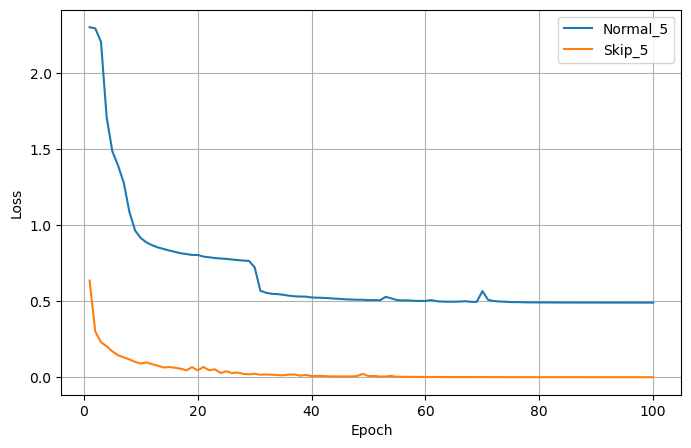

In [10]:
utility.plot_loss({"Normal_5": loss_normal_5, "Skip_5": loss_skip_5}, epochs)